# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Análise Exploratória de Dados de Logística**

## 0\. Introdução

- Analise dos dados de vendas semanais do Walmart para obter insights sobre o desempenho de suas lojas. O conjunto de dados contém informações sobre vendas semanais, temperatura, preço do combustível, IPC (Índice de Preços Consumidor) e desemprego de 45 lojas do Walmart localizadas em diferentes regiões. Meu objetivo é usar técnicas baseadas em dados para descobrir padrões e relacionamentos entre essas variáveis ​​para ajudar na tomada de decisões baseadas em dados.

- Realizei análise exploratória de dados (EDA) para obter uma melhor compreensão do conjunto de dados. Em seguida, usei técnicas de previsão de séries temporais para prever vendas futuras e análise de séries temporais para compreender os padrões e tendências subjacentes nos dados. Por fim, utilizei análise de regressão para identificar as variáveis ​​que tiveram maior impacto nas vendas semanais.

## 1\. Contexto
- Uma loja de varejo que possui várias filiais em todo o país está enfrentando problemas para gerenciar o estoque - para corresponder à demanda em relação ao fornecimento. Você é um cientista de dados, que precisa apresentar insights úteis usando os dados e criar modelos de previsão para prever as vendas para X número de meses/anos.

## 2\. Pacotes e bibliotecas

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

## 3\. Exploração de dados

**3.1 Coleta de dados**

In [2]:
wallmart_df = pd.read_csv('walmart_data.csv', sep = ',')
wallmart_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


**3.2 Data Wrongling**


Descrição das Colunas:

- Store: o número da loja
- Date: a semana das vendas
- Weekly_Sales: as vendas semanais para a loja especificada
- Holiday_Flag: se a semana é uma semana de feriado especial ou não (1 = semana de feriado; 0 = semana não de feriado)
- Temperature: temperatura média na região para a semana especificada
- Fuel_Price: custo do combustível na região para a semana especificada
- CPI: o índice de preços ao consumidor para a semana especificada
- Unemployment: a taxa de desemprego para a região na semana especificada

In [3]:
wallmart_df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [4]:
dados_data = wallmart_df[['Date', 'Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
dados_data['Date'] = pd.to_datetime(dados_data['Date'], format='%d-%m-%Y')  

data_inicio = dados_data['Date'].min()
data_fim = dados_data['Date'].max()

print("Data de Início dos Dados:", data_inicio)
print("Data de Fim dos Dados:", data_fim)

Data de Início dos Dados: 2010-02-05 00:00:00
Data de Fim dos Dados: 2012-10-26 00:00:00


In [5]:
wallmart_df.shape

(6435, 8)

In [6]:
wallmart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
wallmart_df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

**Comentário:** Não tem valores faltantes no dataframe

- Total de lojas no dataframe

In [8]:
total_lojas = wallmart_df['Store'].nunique()
print("Número total de lojas:", total_lojas)

Número total de lojas: 45


- Total de vendas semanais para todas as lojas.

In [9]:
total_vendas_semanais = wallmart_df['Weekly_Sales'].sum()
print('O total de vendas semanais para todas as lojas é: ', total_vendas_semanais)

O total de vendas semanais para todas as lojas é:  6737218987.11


- Qual Média das vendas semanais para cada loja?

In [10]:
media_vendas_semanais =  wallmart_df.groupby('Store')['Weekly_Sales'].mean()
print('Vendas médias semanais de cada loja:')
print(media_vendas_semanais.head())

Vendas médias semanais de cada loja:
Store
1    1.555264e+06
2    1.925751e+06
3    4.027044e+05
4    2.094713e+06
5    3.180118e+05
Name: Weekly_Sales, dtype: float64


- Qual loja tem o maior número de vendas? 

In [11]:
max_loja_vendas_semanais = wallmart_df.groupby('Store')['Weekly_Sales'].sum().idxmax()
print('Loja com o maior número de vendas é a loja: ', max_loja_vendas_semanais)

Loja com o maior número de vendas é a loja:  20


- Qual loja tem o menor número de vendas?

In [12]:
min_loja_vendas_semanais = wallmart_df.groupby('Store')['Weekly_Sales'].sum().idxmin()
print('Loja com o menor número de vendas é a loja: ', min_loja_vendas_semanais)

Loja com o menor número de vendas é a loja:  33


- Qual é a média geral de vendas semanais de todas as lojas

In [13]:
media_geral_vendas = wallmart_df['Weekly_Sales'].mean()
print('Vendas média geral de todas as lojas: ',media_geral_vendas)

Vendas média geral de todas as lojas:  1046964.8775617715


- Qual é a mediana de vendas semanais para todas as lojas?

In [14]:
mediana_vendas = wallmart_df['Weekly_Sales'].median()
print('mediana das vendas semanais de todas as lojas é: ', mediana_vendas)

mediana das vendas semanais de todas as lojas é:  960746.04


- Qual é o desvio padrão das vendas semanais de todas as lojas?

In [15]:
desvio_vendas_semanais = wallmart_df['Weekly_Sales'].std()
print('O desvio padrão de vendas semanais para todas as lojas é de: ', desvio_vendas_semanais)

O desvio padrão de vendas semanais para todas as lojas é de:  564366.6220536975


- Quantas semanas com feriado tem no dataset?

In [16]:
num_feriado_semanas = wallmart_df[wallmart_df['Holiday_Flag'] == 1]['Holiday_Flag'].count()
num_feriado_semanas


450

- Qual é o máximo de vendas semanais para todas as lojas?

In [17]:
max_vendas = wallmart_df['Weekly_Sales'].max()
print("Máximo de vendas semanais:", max_vendas)

Máximo de vendas semanais: 3818686.45


- Qual é o total de vendas semanais durante as semanas de feriados?

In [18]:
vendas_feriado = wallmart_df[wallmart_df['Holiday_Flag'] == 1]['Weekly_Sales'].sum()
print('Total de vendas semanais durante as semanas de feriados: ',vendas_feriado)

Total de vendas semanais durante as semanas de feriados:  505299551.56


- Qual é a média de vendas semanais durante as semanas de feriados?

In [19]:
media_vendas_feriado = wallmart_df[wallmart_df['Holiday_Flag']==1]['Weekly_Sales'].mean()
print('média de vendas semanais durante as semanas de feriados', media_vendas_feriado)

média de vendas semanais durante as semanas de feriados 1122887.8923555557


- Qual é o total de vendas semanais durante semanas sem feriados?

In [20]:
total_ven_non_feriado = wallmart_df[wallmart_df['Holiday_Flag']==0]['Weekly_Sales'].sum()
print('total de vendas semanais durante semanas sem feriados: ', total_ven_non_feriado)

total de vendas semanais durante semanas sem feriados:  6231919435.55


- Qual é a média de vendas semanais durante semanas sem feriados?

In [21]:
media_ven_non_feriado = wallmart_df[wallmart_df['Holiday_Flag']==0]['Weekly_Sales'].mean()
print('média de vendas semanais durante semanas sem feriados:', media_ven_non_feriado )

média de vendas semanais durante semanas sem feriados: 1041256.3802088555


## 4\. Visualização

- Correlação
sns.heatmap() é uma função da biblioteca Seaborn usada para plotar dados retangulares como uma matriz codificada por cores. O parâmetro annot definido como True exibe os valores de correlação no mapa de calor.
Ao examinar o mapa de calor, podemos identificar quaisquer correlações fortes entre as variáveis. O coeficiente de correlação varia de -1 a 1, onde um valor de 1 indica uma correlação positiva , 0 indica nenhuma correlação e -1 indica uma correlação negativa.

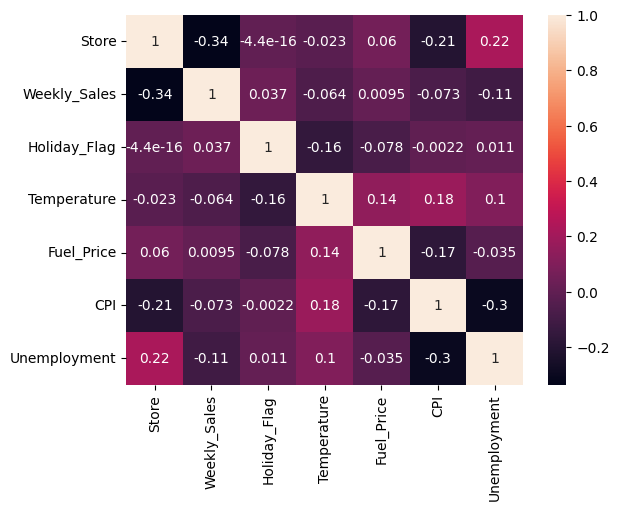

In [22]:
colunas = ['Store','Weekly_Sales','Holiday_Flag','Temperature','Fuel_Price', 'CPI','Unemployment']
grafico_corr = sns.heatmap(wallmart_df[colunas].corr(), annot= True)
plt.show()

**Insights 3:** Percebemos que as semanas de feriado tem um leve efeito nas vendas médias gerais.


- Este código cria um gráfico de barras para visualizar a média de vendas semanais de cada loja no conjunto de dados, agrupadas por sinalizador de feriado. O eixo x representa o número da loja, o eixo y representa a média de vendas semanais dessa loja e o parâmetro matiz é definido como o sinalizador de feriado. Isso significa que serão plotadas barras de cores diferentes para cada loja, dependendo se a semana contém feriado ou não.

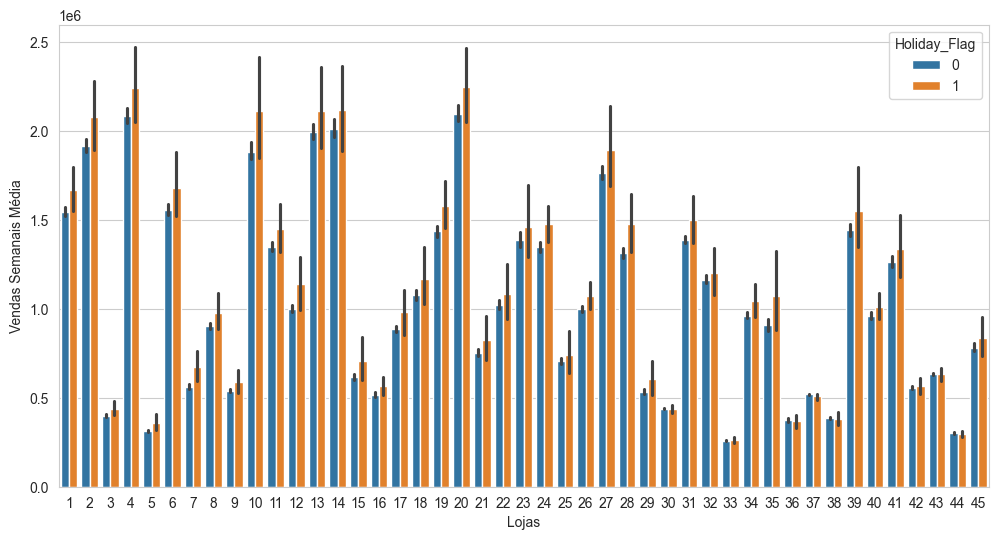

In [23]:
# Visualizando a média de vendas semanais por loja e feriado
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 6))  
    grafico = sns.barplot(x='Store', y='Weekly_Sales', hue='Holiday_Flag', data=wallmart_df)
    grafico.set(xlabel='Lojas',ylabel='Vendas Semanais Média')
    plt.show()

**Insights 3:**  Aumento de vendas semanais média em dias semanas que possuem feriados.

Visualizando a tendência das vendas semanais ao longo do tempo para uma única loja (com maior vendas)

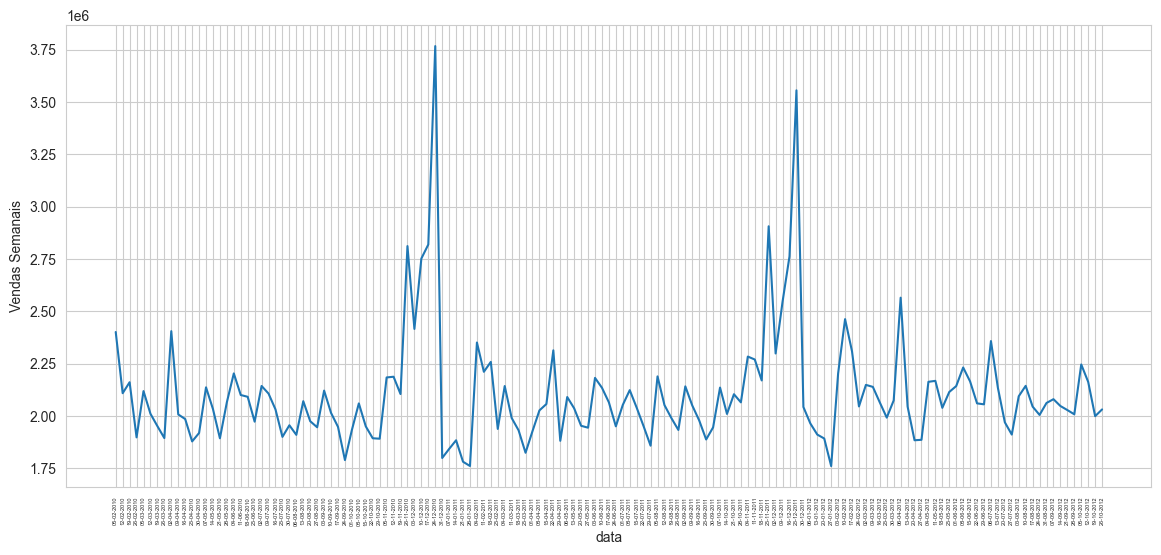

In [24]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize= (14,6))
    loja_df = wallmart_df[wallmart_df['Store'] == 20]
    grafico = sns.lineplot(x = 'Date', y = 'Weekly_Sales', data = loja_df)
    grafico.set(xlabel='data',ylabel='Vendas Semanais')
    plt.xticks(rotation=90, fontsize = 4)
    plt.show()

**Insights 3:** Percebemos um padrão em relação as vendas semanais durante a epoca de fim de ano.

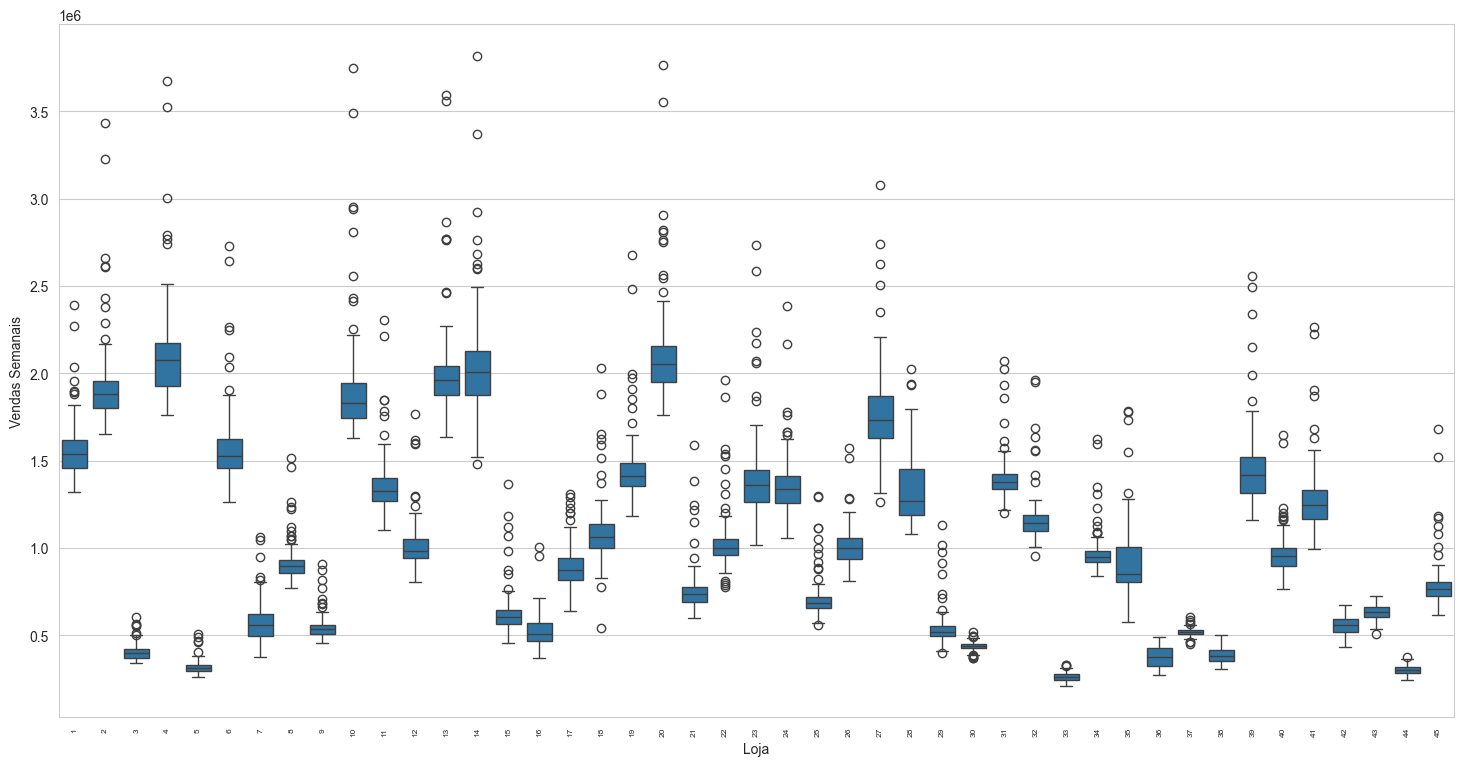

In [25]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize= (18,9))
    grafico = sns.boxplot(x = 'Store', y ='Weekly_Sales', data = wallmart_df)
    grafico.set(xlabel= 'Loja', ylabel= 'Vendas Semanais')
    plt.xticks(rotation = 90, fontsize = 6)
    plt.show()

**Insights 3:**  Todas as lojas tem um padrão, com pontos de vendas maiores durante um periado.


---

## 5\. Predição  

- Time-series Forecasting

- A previsão de série temporal é uma técnica estatística usada para prever valores futuros com base em valores observados anteriormente em um conjunto de dados de série temporal. Esta é uma implementação de previsão de séries temporais usando o modelo SARIMAX.

- A primeira etapa é dividir os dados em conjuntos de treinamento e teste usando a função iloc. O conjunto de treinamento contém todos os dados, exceto as últimas 10 observações, enquanto o conjunto de teste contém apenas as últimas 10 observações.

- O próximo passo é selecionar a variável endógena (ou seja, a variável a ser prevista) que é ‘Vendas_Semanais’ neste caso.

- O modelo SARIMAX é então ajustado aos dados de treinamento. O parâmetro order especifica a ordem dos componentes autoregressivos, diferenciais e de média móvel, enquanto o parâmetro season_order especifica a ordem dos componentes sazonais.

- O método Forecast() é então usado para prever as vendas futuras para as próximas 10 semanas. Finalmente, o desempenho do modelo é avaliado usando a raiz do erro quadrático médio (RMSE).

**5.1 Treinando meu modelo SARIMAX**

# Modelo SARIMAX

In [26]:
wallmart_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [27]:
# Preparar os dados

dados = wallmart_df[['Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
dados.loc[:, 'Date'] = pd.to_datetime(dados['Date'], format='%d-%m-%Y') 
dados.set_index('Date', inplace=True) 

In [28]:
#Dividindo os dados em conjuntos de treinamento e teste
train = dados.iloc[:-10]
test = dados.iloc[-10:]

In [29]:
#Selecione a variável endógena a ser prevista (ou seja, 'Weekly_Sales')
dados_train = train ['Weekly_Sales']
dados_test = test ['Weekly_Sales']

In [30]:
model = SARIMAX(dados_train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 26), freq=None)
resultado = model.fit()

c:\Users\Gabriel Canuto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gabriel Canuto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gabriel Canuto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gabriel Canuto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index

- Prevendo os valores para as próximas 10 semanas.

In [31]:
#Previsão de vendas futuras para as próximas 10 semanas
previsao = resultado.forecast(steps=10)
print(previsao)


6425    778952.113845
6426    718735.166511
6427    730026.570810
6428    710723.018435
6429    713717.551411
6430    698778.081784
6431    775914.771362
6432    714968.418179
6433    746952.519200
6434    731830.800292
Name: predicted_mean, dtype: float64


c:\Users\Gabriel Canuto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Gabriel Canuto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


- **Análise de Série Temporal:**

A análise de série temporal é uma técnica estatística usada para analisar e modelar dados dependentes do tempo. Envolve estudar os padrões, tendências e relacionamentos entre pontos de dados ao longo do tempo para descobrir estruturas subjacentes e fazer previsões sobre valores futuros.

In [32]:
wallmart_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [33]:
wallmart_tempo_df = wallmart_df.set_index(keys=['Date'])

In [34]:
wallmart_tempo_df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
05-02-2010,1,1643690.90,0,42.31,2.572,211.096358,8.106
12-02-2010,1,1641957.44,1,38.51,2.548,211.242170,8.106
19-02-2010,1,1611968.17,0,39.93,2.514,211.289143,8.106
26-02-2010,1,1409727.59,0,46.63,2.561,211.319643,8.106
05-03-2010,1,1554806.68,0,46.50,2.625,211.350143,8.106


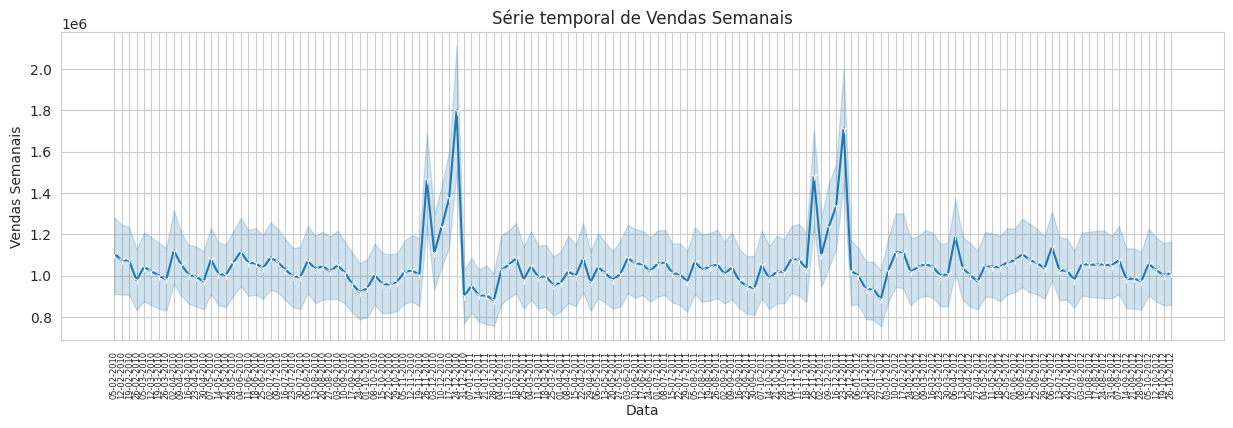

In [35]:
with sns.axes_style('whitegrid'):

  grafico = sns.lineplot(data=wallmart_tempo_df, x='Date', y='Weekly_Sales', marker="1")
  grafico.set(title='Série temporal de Vendas Semanais', ylabel='Vendas Semanais', xlabel='Data')
  plt.xticks(rotation = 90, fontsize = 6)
  grafico.figure.set_size_inches(15, 4)

In [36]:
if not isinstance(wallmart_tempo_df.index, pd.DatetimeIndex):
    wallmart_tempo_df.index = pd.to_datetime(wallmart_tempo_df.index, format='%d-%m-%Y')

In [37]:
wallmart_tempo_df = wallmart_tempo_df.resample(rule='W').mean()

In [38]:
decomposicao = seasonal_decompose(wallmart_tempo_df['Weekly_Sales'], model='additive')
residuo = decomposicao.resid
tendencia = decomposicao.trend
sazonalidade = decomposicao.seasonal

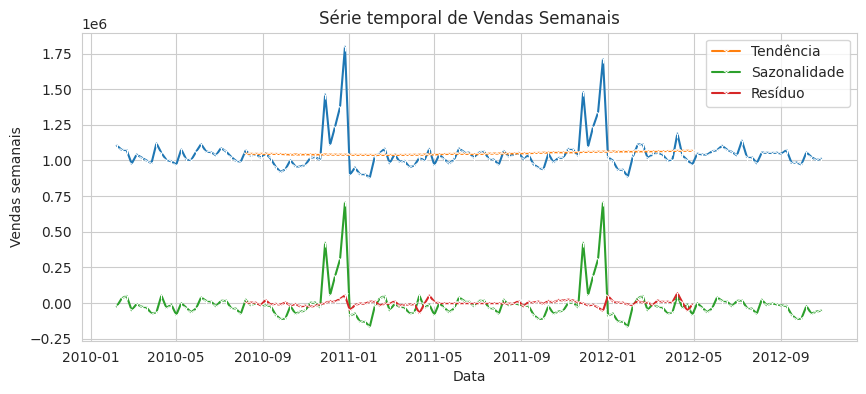

In [39]:
with sns.axes_style('whitegrid'):

  grafico = sns.lineplot(data=wallmart_tempo_df, x='Date', y='Weekly_Sales', marker="1")
  grafico = sns.lineplot(data=pd.DataFrame({'Date': tendencia.index, 'Weekly_Sales': tendencia.values}), x='Date', y='Weekly_Sales', label='Tendência', marker="1")
  grafico = sns.lineplot(data=pd.DataFrame({'Date': sazonalidade.index, 'Weekly_Sales': sazonalidade.values}), x='Date', y='Weekly_Sales', label='Sazonalidade', marker="1")
  grafico = sns.lineplot(data=pd.DataFrame({'Date': residuo.index, 'Weekly_Sales': residuo.values}), x='Date', y='Weekly_Sales', label='Resíduo', marker="1")
  
  
  grafico.set(title='Série temporal de Vendas Semanais', ylabel='Vendas semanais', xlabel='Data')
  grafico.figure.set_size_inches(10, 4)

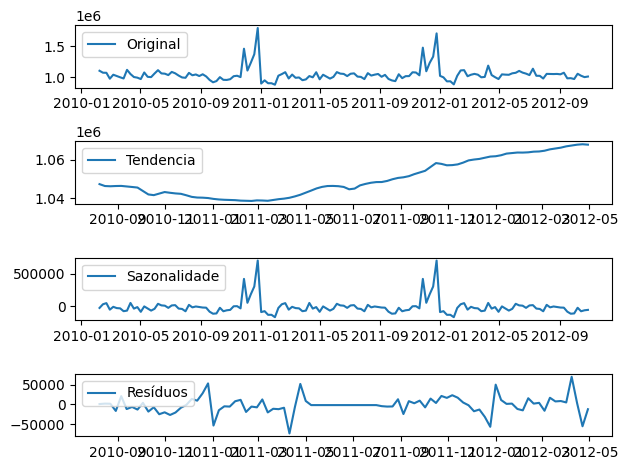

In [41]:
#série temporal decomposta
plt.subplot(411)
plt.plot(wallmart_tempo_df['Weekly_Sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sazonalidade,label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuo, label='Resíduos')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

- **Avaliando o desempenho do modelo usando RMSE**

In [42]:
wallmart_df.tail(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6425,45,24-08-2012,718232.26,0,72.62,3.834,191.344887,8.684
6426,45,31-08-2012,734297.87,0,75.09,3.867,191.461281,8.684
6427,45,07-09-2012,766512.66,1,75.70,3.911,191.577676,8.684
6428,45,14-09-2012,702238.27,0,67.87,3.948,191.699850,8.684
6429,45,21-09-2012,723086.20,0,65.32,4.038,191.856704,8.684
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667
6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667


In [43]:
rmse = np.sqrt(mean_squared_error(dados_test, previsao))
print(f'RMSE: {rmse:.2f}')

RMSE: 30741.97


In [44]:
#Média valores reais
media_valores_reais = dados_test.mean()

rmse_porcentual = (rmse / media_valores_reais) * 100
print(f'Porcentagem de erro: {rmse_porcentual:.2f}%')

Porcentagem de erro: 4.21%


**Comentario:** Em média, nossas previsões estão erradas em cerca de 30.741,97 unidades em comparação com os números reais de vendas. Isso significa que a previsão teve um erro de 4.21%

**5.2 Treinando meu modelo por regressão linear**

In [45]:
wallmart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [46]:
wallmart_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


**Comentario**: O modelo de regressão linear precisa converter o dados do tipo objeto 

In [47]:
#convertendo coluna 'Data' para datetime object
wallmart_df['Date'] = pd.to_datetime(wallmart_df['Date'], format='%d-%m-%Y')
wallmart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [48]:
# Extraindo o ano e o mês como novos recursos
wallmart_df['Year'] = wallmart_df['Date'].dt.year
wallmart_df['Month'] = wallmart_df['Date'].dt.month

In [49]:
# Definindo os recursos a serem usados ​​para previsão
recursos = ['Year', 'Month', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
X_train, X_test, y_train, y_test = train_test_split(
    wallmart_df[recursos], 
    wallmart_df['Weekly_Sales'], 
    test_size=0.2, 
    random_state=42
    )

In [50]:
# treinar meu modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [51]:
X_train.shape

(5148, 6)

In [52]:
X_test.shape

(1287, 6)

In [53]:
#Faça previsões no conjunto de testes
y_pred = model.predict(X_test)

In [54]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 559497.1551879063


c:\Users\Gabriel Canuto\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [55]:
mean_value = np.mean(y_test)
rmse_percentage = (rmse / mean_value) * 100
print("RMSE como porcentagem:", rmse_percentage)

RMSE como porcentagem: 53.041013655730374


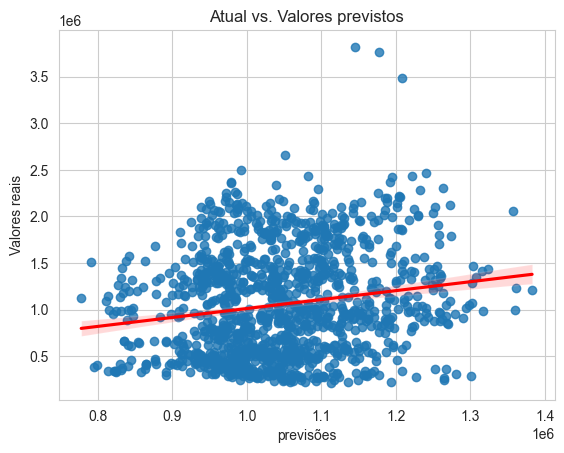

In [56]:
with sns.axes_style('whitegrid'): 
    grafico = sns.regplot(x=y_pred, y=y_test, line_kws={'color': 'red'})
    grafico.set(title='Atual vs. Valores previstos', xlabel= 'previsões', ylabel= 'Valores reais')
    plt.show()

**Comentário:** Este tipo de gráfico é especialmente útil para avaliar a precisão do seu modelo de regressão. Ele fornece uma maneira visual de entender como as previsões se comparam aos valores reais e pode ajudar a identificar padrões ou áreas onde o modelo precisa ser ajustado ou melhorado

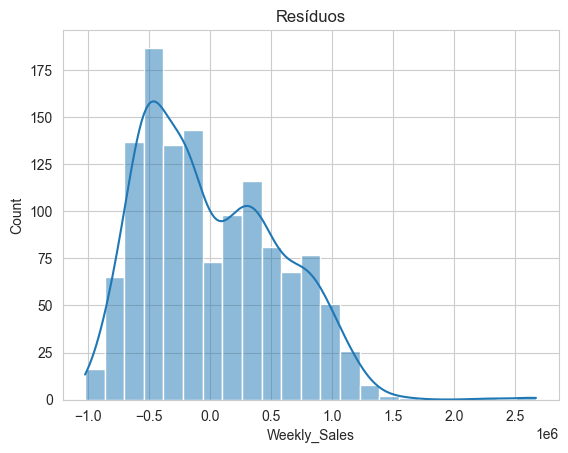

In [57]:
#Verificando a normalidade da suposição de resíduos
with sns.axes_style('whitegrid'): 
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True)
    plt.title('Resíduos')
    plt.show()

**Comentário:** gráfico resultante mostrará a distribuição dos resíduos do modelo de regressão. Se os resíduos seguirem aproximadamente uma distribuição normal, o gráfico terá uma forma de sino (bell-shaped curve) e a estimativa da função de densidade kernel (linha suave) seguirá essa forma.

Verificar a normalidade dos resíduos é importante porque a validade dos testes de hipóteses e dos intervalos de confiança no modelo de regressão linear depende dessa suposição. Se os resíduos não seguirem uma distribuição normal, pode ser necessário considerar transformações nos dados ou explorar modelos alternativos.

---

**Resumo:** 
- A loja 20 teve as maiores vendas e a loja 33 as menores.
- As vendas foram maiores nos feriados.
- A temperatura teve uma leve relação positiva com as vendas semanais.
- O desemprego teve uma leve relação negativa com as vendas.
- As vendas cresceram ao longo do tempo, com variações sazonais.
- As vendas médias mensais também cresceram ao longo do tempo.
--- 
Por que isso importa?

Para os compradores, isso mostra como fatores como feriados e clima afetam as compras.
Para políticos, isso ajuda a criar políticas para apoiar o varejo.
Varejistas podem usar isso para prever vendas e planejar estoques.
Identificar quais fatores influenciam mais as vendas pode ajudar a aumentá-las.
Resumindo, este trabalho fornece informações importantes sobre o varejo, ajudando compradores, varejistas e políticos a tomarem decisões mais informadas.